<a href="https://colab.research.google.com/github/msfalif404/senam-kaggle/blob/main/Kaggle_Playground_S5E2_Backpack_Prediction_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Playground - S5E2 - Backpack Prediction Challenge

## Import Library

In [182]:
# !pip install xgboost
# !pip install catboost
# !pip install lightgbm
# !pip install scikit-learn==1.3.1
# !pip install optuna

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Reading The Dataset

In [184]:
df = pd.read_csv('/content/train.csv')

train_df = df.copy()
test_df = pd.read_csv('/content/test.csv')

test_df_id = test_df['id']

train_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

## Data Overview

In [185]:
train_df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [186]:
test_df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


In [187]:
train_df.isnull().sum()

,0
Brand,9705
Material,8347
Size,6595
Compartments,0
Laptop Compartment,7444
Waterproof,7050
Style,7970
Color,9950
Weight Capacity (kg),138
Price,0


In [188]:
test_df.isnull().sum()

,0
Brand,6227
Material,5613
Size,4381
Compartments,0
Laptop Compartment,4962
Waterproof,4811
Style,5153
Color,6785
Weight Capacity (kg),77


### Missing Value Heatmap

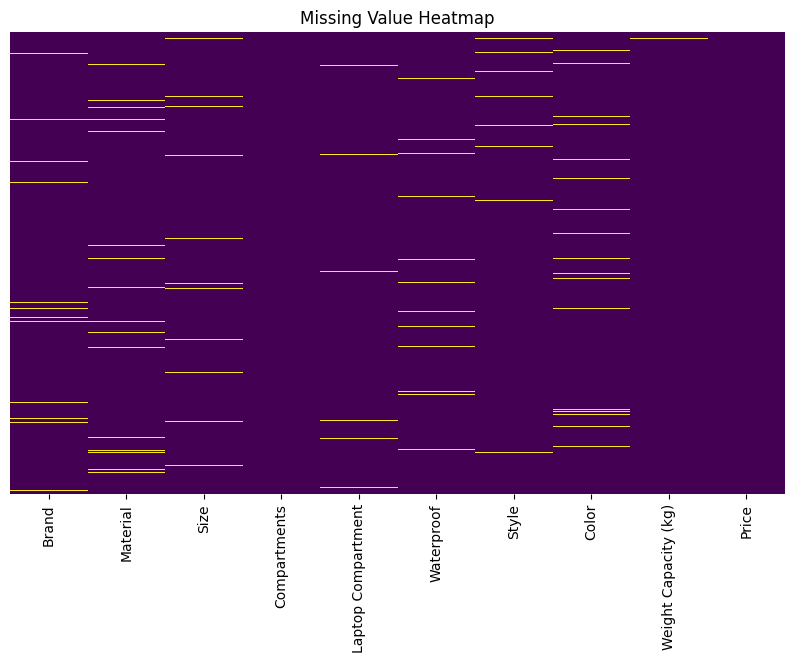

In [189]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Value Heatmap")
plt.show()

### Missing Value Correlation

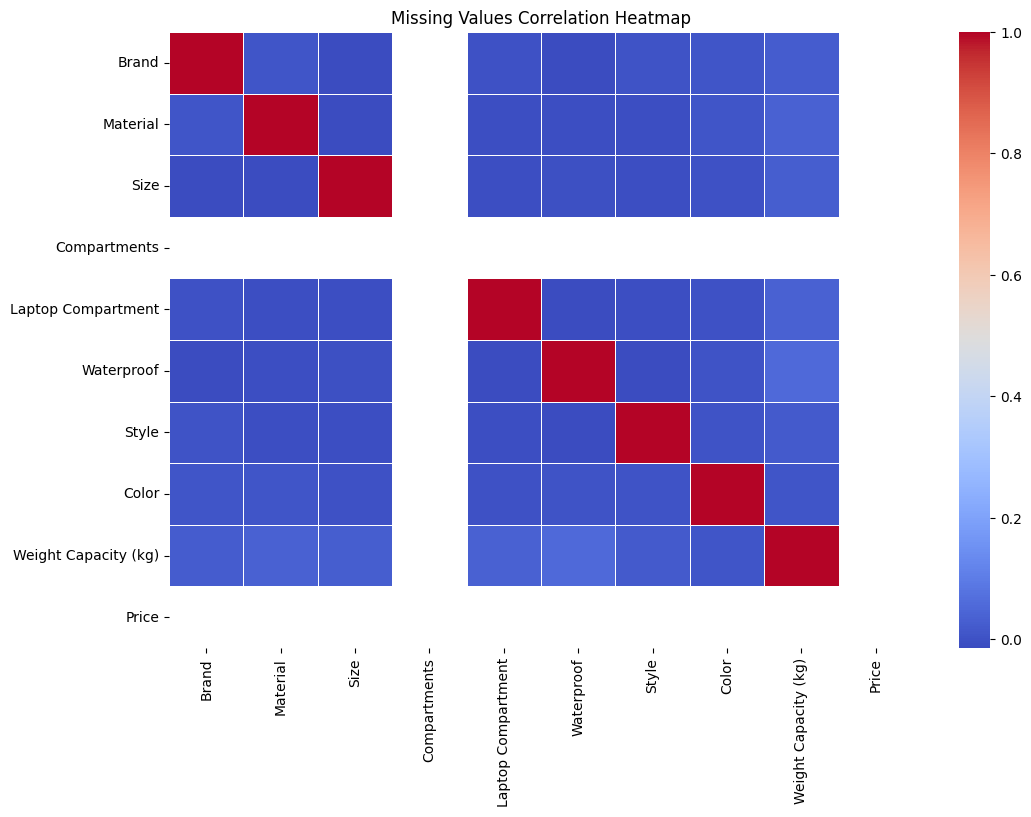

In [190]:
# Check missing values correlation
missing_corr = train_df.isnull().corr()

# Plot heatmap for missing values correlation
plt.figure(figsize=(12, 8))
sns.heatmap(missing_corr, cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title('Missing Values Correlation Heatmap')
plt.show()

### Correlation Between Features

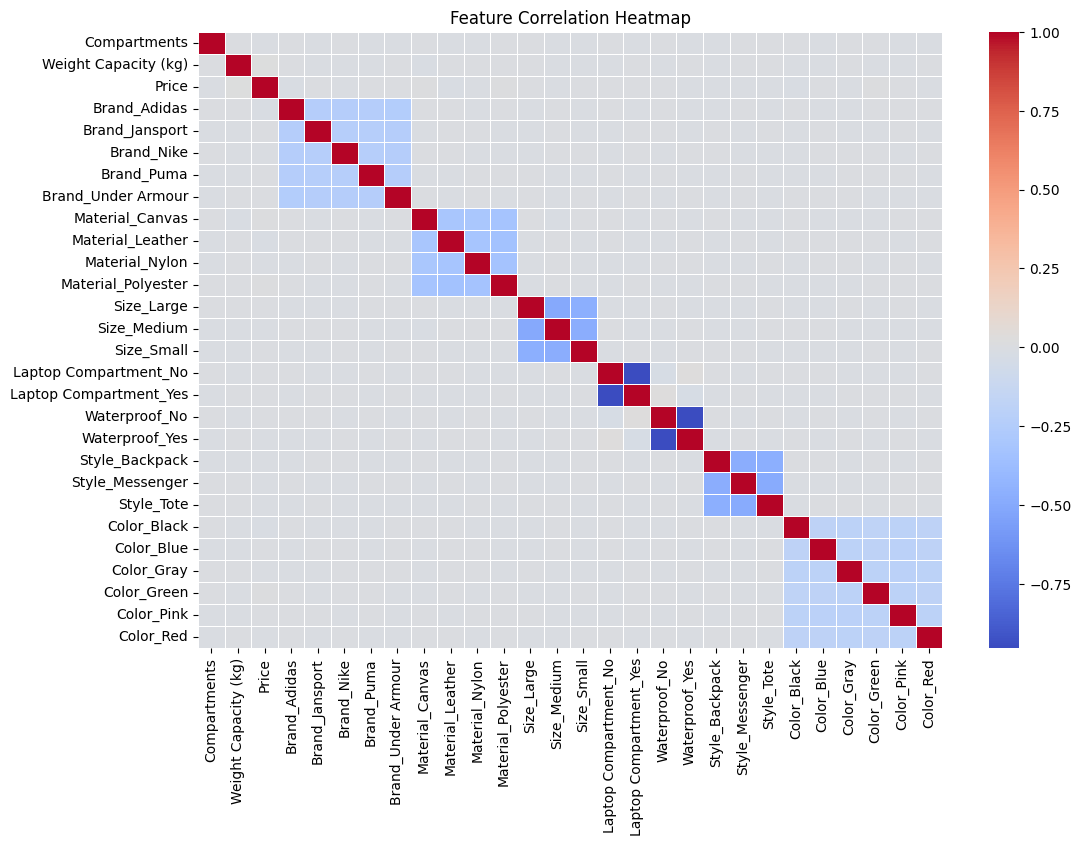

In [191]:
# Identify categorical variables
categorical_features = train_df.select_dtypes(include=['object', 'category']).columns

# One-hot encode categorical variables
train_encoded = pd.get_dummies(train_df, columns=categorical_features)

# Compute correlation matrix
correlation_matrix = train_encoded.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

### Outlier

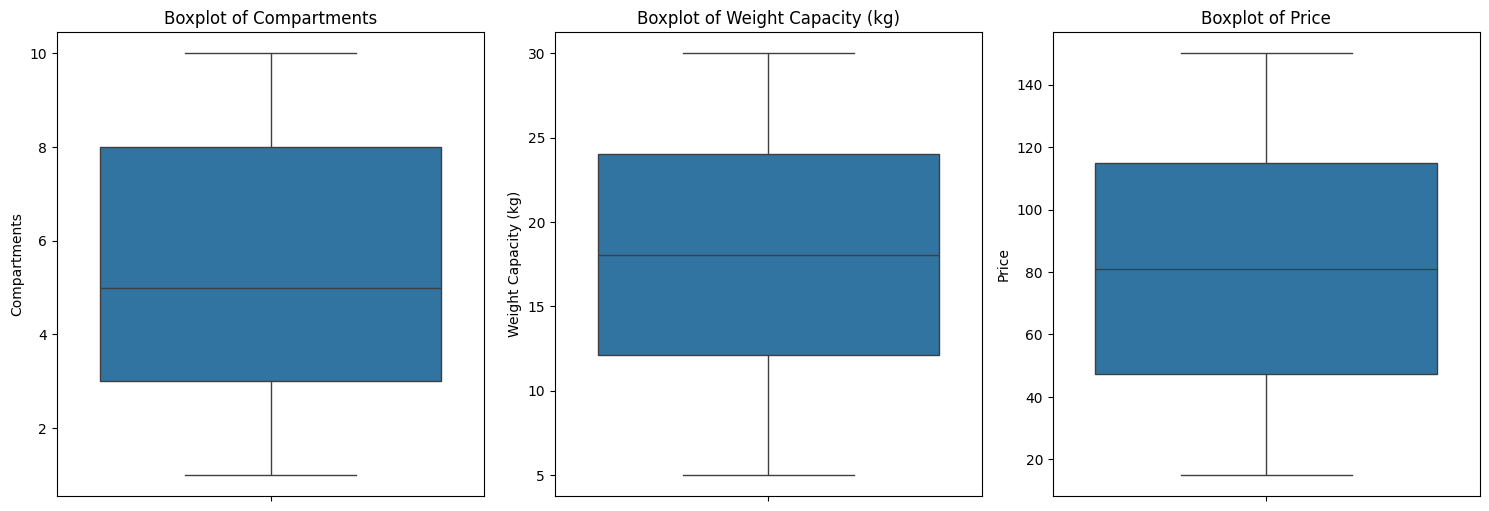

In [192]:
# Plot boxplots for detecting outliers in numerical columns
numerical_features = train_df.select_dtypes(include=['number']).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features) // 3 + 1, 3, i)
    sns.boxplot(y=train_df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.show()

### Target Variabel Distribution

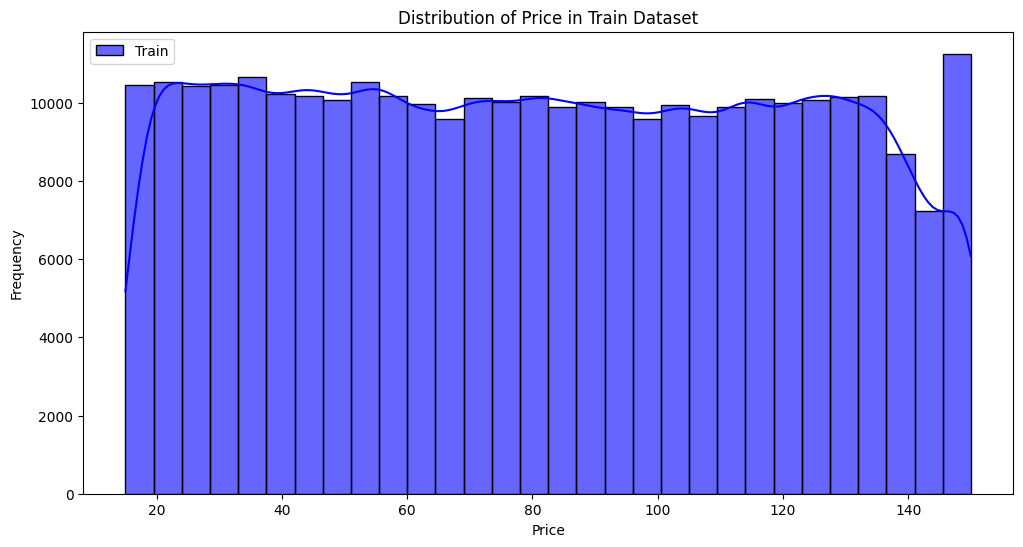

In [193]:
# Plot histogram for Weight Capacity (kg) comparison
plt.figure(figsize=(12, 6))
sns.histplot(train_df['Price'], color='blue', label='Train', kde=True, bins=30, alpha=0.6)
plt.title('Distribution of Price in Train Dataset')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Data Pre-processing

### Encoding Categorical Variable

In [194]:
categorical_features = train_df.select_dtypes(include=['object', 'category', 'bool']).columns

train_df_encoded = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)
test_df_encoded = pd.get_dummies(test_df, columns=categorical_features, drop_first=True)

### Filling Missing Value

In [195]:
train_features = train_df_encoded.drop(columns=['Price'], errors='ignore')
train_target = train_df['Price']

In [ ]:
knn_imputer = KNNImputer(n_neighbors=5)

train_df_imputed = pd.DataFrame(knn_imputer.fit_transform(train_features), columns=train_features.columns)
test_df_imputed = pd.DataFrame(knn_imputer.transform(test_df_encoded), columns=train_features.columns)

train_df_imputed['Price'] = train_target

In [ ]:
train_df_imputed.isnull().sum()

In [ ]:
test_df_imputed.isnull().sum()

## Feature Engineering

### Bag Capacity

In [ ]:
# Create Weight Capacity Category using quartiles
q1 = train_df['Weight Capacity (kg)'].quantile(0.25)
q2 = train_df['Weight Capacity (kg)'].quantile(0.50)
q3 = train_df['Weight Capacity (kg)'].quantile(0.75)

bins = [0, q1, q3, np.inf]
labels = ['Low Capacity', 'Medium Capacity', 'High Capacity']

train_df_imputed['Weight Capacity Category'] = pd.cut(train_df['Weight Capacity (kg)'], bins=bins, labels=labels, include_lowest=True)
test_df_imputed['Weight Capacity Category'] = pd.cut(test_df['Weight Capacity (kg)'], bins=bins, labels=labels, include_lowest=True)

In [ ]:
train_df_encoded = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)
test_df_encoded = pd.get_dummies(test_df, columns=categorical_features, drop_first=True)

## Splitting The Dataset

In [ ]:
X = train_df_encoded.drop(['id', 'Price'], axis=1)
y = train_df_encoded['Price']

## Cross Validation (KFold)

In [ ]:
cv = KFold(n_splits = 5)

## Defining Model

In [ ]:
xgb_model = XGBRegressor(
    n_estimators=1000,
    max_depth=13,
    learning_rate=0.05,
    objective='reg:squarederror',
    missing=np.nan,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.5,
)

In [ ]:
catboost_model = CatBoostRegressor(
    n_estimators=1000,
    max_depth=13,
    learning_rate=0.05,
    loss_function='RMSE',
    od_type='Iter',
    subsample=0.8,
    reg_lambda=1.5,
    random_seed=42,
    bootstrap_type='Bernoulli',
    verbose=False
)

In [ ]:
lgbm_model = LGBMRegressor(
    n_estimators=1000,
    max_depth=13,
    learning_rate=0.05,
    objective='regression',
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.5,
    boosting_type='gbdt',
    verbosity=-1
)

In [ ]:
models = {
    'XGBoost': xgb_model,
    'CatBoost': catboost_model,
    'LightGBM': lgbm_model
}

## Training Model

In [ ]:
for model_name, model in models.items():
    print(f"\nTraining {model_name} Model")

    for fold, (train_index, test_index) in enumerate(cv.split(X), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train model
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)

        # Evaluate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f'RMSE for fold {fold}: {rmse:.4f}')

## Hyperparameter Tuning (CatBoost)

In [ ]:
import optuna

def objective(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 6, 16),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'loss_function': 'RMSE',
        'random_seed': 42,
    }

    model = CatBoostRegressor(**params)
    rmse_scores = []

    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

In [ ]:
# Create a study object
study = optuna.create_study(direction='minimize')

# Run the optimization
study.optimize(objective, n_trials=3)

In [ ]:
# Get the best hyperparameters
best_params = study.best_params

print("Best Hyperparameters:", best_params)

In [ ]:
final_model = lgbm_model

## Re-training

In [ ]:
final_model.fit(X, y)

In [ ]:
X.shape

In [ ]:
test_df.shape

In [ ]:
y_pred = final_model.predict(test_df_encoded)

## Feature Importance

In [ ]:
# Feature importance visualization
feature_importance = final_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance, y=feature_names, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Visualization')
plt.show()

In [ ]:
pred_result = pd.DataFrame({
    'id': test_df_id,
    'Price': y_pred
})

pred_result.to_csv('first_submission.csv')